In [1]:
import numpy as np
import math
import random
import simpy
import pandas as pd
import scipy.stats as stats
import string
#import pandasql as ps
#import plotly.graph_objects as go
#import plotly
import matplotlib as mpl
import matplotlib.pyplot as plt

random.seed(198666)

# Initialising the simulation parameters like maximum speed, acceleration and exit speed of train

In [2]:
def Total_time(Total_Distance):  # The time spent at top speed
    Time = Total_Distance / 300
    return (Time)

def Block_Location(n):
    Block_Loc = np.linspace(0, 145, n + 1)
    return (Block_Loc)

def Decrease_Time_Exit_Speed(Dec_Dist):  # The Exit Speed
    Out_Dict = {}
    Out_Dict['Exit_Speed'] = math.sqrt(max(300 ** 2 - 2 * 4665.6 * Dec_Dist, 0))
    Out_Dict['Time'] = 2 * Dec_Dist / (300 + Out_Dict['Exit_Speed'])
    return (Out_Dict)

def Acceleration_Time(Entry_Speed):  # The Acc Time
    Output = {}
    Output['Time'] = ((300 / 3600 - Entry_Speed / 3600) / 0.72) / 3.6
    Output['Dist'] = ((Entry_Speed / 3600) * (Output['Time'] * 360) + 0.5 * 0.72 * (Output['Time'] * 360) ** 2) / 10
    return (Output)

# Additional parameters like wait_time_in_block and random_time are created

In [3]:
def Time_In_Block(i, Block_Loc, slow_down_ind, Entry_Speed):
    dist = Block_Loc[i] - Block_Loc[i - 1]
    #takes 15k for train to reach full speed and then decelerate
    Pre_Sig_Dist = 9.640
    TS_Dist = dist - Acceleration_Time(Entry_Speed)['Dist'] - slow_down_ind * Pre_Sig_Dist
    time = Acceleration_Time(Entry_Speed)['Time'] + Total_time(TS_Dist) + slow_down_ind * Decrease_Time_Exit_Speed(Pre_Sig_Dist)['Time']

    #Provide for weather etc.
    time_random = np.random.normal(time,time/10)
    return (time_random)

# Class for wait_time for all three stations

In [4]:
class wait_time:
    def __init__(self):
        self.wt = 0

    def London_Euston(self):
        self.wt = 0
        return (self.wt)

    def London_OOC(self):
        self.wt = (2 / 60) + np.random.exponential(1 / 60)
        return (self.wt)

    def Birmingham_Int(self):
        self.wt = (2 / 60) + np.random.exponential(1 / 60)
        return (self.wt)

    def Birmingham_Curzon(self):
        self.wt = 0
        return (self.wt)

# Train class 

In [5]:
class Train(object):
    def __init__(self, env, sig_blocks, res, wait_class):
        self.sig_blocks=sig_blocks
        self.res = res
        self.wait_class = wait_class
        self.env=env
        
    def daytime(t):
        t=int(t)
        return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
    def now(env):
        return daytime(env.now)

    def Execute_Train(self ,ID):
        wc = self.wait_class
        row = {}
        row['No_Blocks'] = len(self.sig_blocks) - 1 # London and two birmingham blocks dont add to the total
        row['Train_No'] = ID

        yield (self.env.timeout(wc.London_Euston()))
        lon = self.res['London'].request()
        yield (lon)
        print('Train {} leaves London Euston at {}'.format(ID, daytime(self.env.now * 3600)))
        #row['Delay'] = self.env.now *60
  
        row['Departure_Time'] = daytime(self.env.now * 3600)
        yield (self.env.timeout(5 / 60))  # 5 minute wait
        print('Train {} arrives in London Old Oak Common at {}'.format(ID, daytime(self.env.now * 3600)))
        #row['Delay'] = self.env.now *60
        yield (self.env.timeout(wc.London_OOC()))  # wait for mandatory two mins with an extra delay of an average of one minute
        print('Train {} leaves London Old Oak Common at {}'.format(ID, daytime(self.env.now * 3600)))
        #row['Delay'] = self.env.now *60

        req_list = []
        req_list.append(self.res['Straight'][0].request())
        yield (req_list[0])
        yield(self.res['London'].release(lon))
        # Enter the long straight between London and brimingham
        SD_Ind = False
        Entry_speed = 0
        for i in range(1, len(self.sig_blocks)):
            print('Train {} enters signalling block {} at {}'.format(ID, i, daytime(self.env.now * 3600)))
            if i == len(self.sig_blocks) - 1:
                SD_Ind = True
            elif self.res['Straight'][i].count > 0:
                SD_Ind = True
                Entry_speed = 0
            elif i != 1:
                SD_Ind = False
                Entry_speed = 300

            Tib = Time_In_Block(i, self.sig_blocks, SD_Ind, Entry_speed)
            yield (self.env.timeout(Tib))
           


            # When we arrive at birmingham
            if i == len(self.sig_blocks) - 1:
                print('Train {} arrives in Birmingham Interchange at {}'.format(ID , daytime(self.env.now * 3600)))
                yield (self.env.timeout(wc.Birmingham_Int()))  # wait for mandatory two mins with an extra delay of an average of one minute
                #row['Delay'] = self.env.now *60
                bir1 = self.res['Birmingham'][0].request()
                yield (bir1)

            else:
                print('Train {} reaches end of signalling block {} at {}'.format(ID ,i , daytime(self.env.now * 3600)))
                req_list.append(self.res['Straight'][i].request())
                yield (req_list[i])

            self.res['Straight'][i - 1].release(req_list[i - 1])

        print('Train {} leaves Birmingham Interchange at {}'.format(ID, daytime(self.env.now * 3600)))
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        #row['Delay'] = self.env.now *60
        print('Train {} is at Birmingham Signalling Block {}'.format(ID, daytime(self.env.now * 3600)))
        bir2 = self.res['Birmingham'][1].request()
        yield (bir2)
        self.res['Birmingham'][0].release(bir1)
        yield (self.env.timeout(4.5 / 60))  # 4.5 Min journey
        #row['Delay'] = self.env.now *60
        row['Arrival_Time'] = daytime(self.env.now * 3600)
        self.res['Birmingham'][1].release(bir2)
        print('Train {} arrives in Birmingham Curzon Street Common at {}'.format(ID, daytime(self.env.now * 3600)))

        #append to output data frame
        global df_out
        df_out = df_out.append(row, ignore_index=True)
        
    def daytime(t):
        t=int(t)
        return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
    def now(env):
        return daytime(env.now)

# All three stations are inputted with appropriate simulation parameters

In [6]:
import datetime
class London_2_Birmingham(object):
    def __init__(self, env, k, Times, Day_Num, wait_class, start, stop):
        self.env = env
        self.k = k
        self.Times = Times
        self.Day_Num = Day_Num
        self.wait_class = wait_class
        self.start = start
        self.stop = stop
        self.df = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': [], 'Delay': [], 'Train_Time_Interval': []})
        self.action = env.process(self.run(self.k, self.Times))
        

    # The overall process
    def run(self, k, Times):
        sig_blocks = Block_Location(k)

        # create resources
        avail = {}
        avail['Straight'] = self.Resources(k)  # A vector of train locations, True indcates presence of train
        avail['London'] = simpy.Resource(self.env, capacity=1)
        avail['Birmingham'] = self.Resources(2)

        global df_out
        df_out = pd.DataFrame(
            {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
             'Trains_PH': [], 'Delay': [], 'Train_Time_Interval': []})

        Train_obj = Train(self.env, sig_blocks, avail, self.wait_class())

        x = 1  # Train ID
        self.env.process(Train_obj.Execute_Train(x))
        #self.df = self.df.append(row_vect, ignore_index=True)

        while True:
            yield (self.env.timeout(1 / Times))  # Times per hour
            x = x + 1
            self.env.process(Train_obj.Execute_Train(x))
            #self.df = self.df.append(row_vect, ignore_index=True)

    def Resources(self, k):
        out_l = []
        for i in range(k):
            out_l.append(simpy.Resource(self.env, capacity=1))
        return (out_l)

    def Return_Df(self):
        self.df = df_out        
        self.df['Day'] = self.Day_Num
        self.df['Train_Time_Interval'] = float(60 / self.Times)
        self.df['Trains_PH'] = self.Times
        return (self.df)

# Time and Day conversion

In [7]:
def daytime(t):
        t=int(t)
        return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def now(env):
        return daytime(env.now)

# Simulation class

In [8]:
def Simulation(trains,signals,n_days):  # few Variable Inputs, keep everything consistent

    Output_df = pd.DataFrame(
        {'No_Blocks': [], 'Train_No': [], 'Departure_Time': [], 'Arrival_Time': [], 'Journey_Time': [], 'Day': [],
         'Trains_PH': [], 'Delay': [], 'Train_Time_Interval': []})

    for Tr in trains:
        for sig in signals:
            for day in range(1, n_days+1): 
                env = simpy.Environment()
                print(env.now)
                proc = London_2_Birmingham(env, sig, Tr, day, wait_time, start=6*3600, stop=7*3600)
                env.run(until=19)  # Assume trains operate 6am to midnight 18 hours
                Output_df = Output_df.append(proc.Return_Df(), ignore_index=True)
    return (Output_df)
Trains_Per_Hour = [6]
Sig_blocks = [3]

# Simulating the trains with 6 trains per hour and 3 signals blocks

In [9]:
Simulation_Data_1 = Simulation(Trains_Per_Hour,Sig_blocks,1)

0
Train 1 leaves London Euston at 00:00:00
Train 1 arrives in London Old Oak Common at 00:05:00
Train 1 leaves London Old Oak Common at 00:09:42
Train 1 enters signalling block 1 at 00:09:42
Train 2 leaves London Euston at 00:10:00
Train 2 arrives in London Old Oak Common at 00:15:00
Train 2 leaves London Old Oak Common at 00:19:23
Train 1 reaches end of signalling block 1 at 00:23:20
Train 1 enters signalling block 2 at 00:23:20
Train 2 enters signalling block 1 at 00:23:20
Train 3 leaves London Euston at 00:23:20
Train 3 arrives in London Old Oak Common at 00:28:20
Train 3 leaves London Old Oak Common at 00:30:25
Train 1 reaches end of signalling block 2 at 00:33:06
Train 1 enters signalling block 3 at 00:33:06
Train 2 reaches end of signalling block 1 at 00:35:23
Train 2 enters signalling block 2 at 00:35:23
Train 3 enters signalling block 1 at 00:35:23
Train 4 leaves London Euston at 00:35:23
Train 4 arrives in London Old Oak Common at 00:40:23
Train 4 leaves London Old Oak Common 

Train 43 is at Birmingham Signalling Block 11:33:13
Train 47 arrives in London Old Oak Common at 11:34:03
Train 47 leaves London Old Oak Common at 11:36:51
Train 43 arrives in Birmingham Curzon Street Common at 11:37:43
Train 46 reaches end of signalling block 1 at 11:41:12
Train 45 reaches end of signalling block 2 at 11:43:18
Train 44 arrives in Birmingham Interchange at 11:43:37
Train 44 leaves Birmingham Interchange at 11:46:19
Train 45 enters signalling block 3 at 11:46:19
Train 46 enters signalling block 2 at 11:46:19
Train 47 enters signalling block 1 at 11:46:19
Train 48 leaves London Euston at 11:46:19
Train 44 is at Birmingham Signalling Block 11:50:49
Train 48 arrives in London Old Oak Common at 11:51:19
Train 48 leaves London Old Oak Common at 11:53:37
Train 44 arrives in Birmingham Curzon Street Common at 11:55:19
Train 47 reaches end of signalling block 1 at 11:58:05
Train 46 reaches end of signalling block 2 at 11:58:08
Train 45 arrives in Birmingham Interchange at 12:00

In [10]:
Trains_PH = [3]
Sig_blocks = [5]

Simulation_Data_2 = Simulation(Trains_Per_Hour,Sig_blocks,1)

0
Train 1 leaves London Euston at 00:00:00
Train 1 arrives in London Old Oak Common at 00:05:00
Train 1 leaves London Old Oak Common at 00:09:07
Train 1 enters signalling block 1 at 00:09:07
Train 2 leaves London Euston at 00:10:00
Train 2 arrives in London Old Oak Common at 00:15:00
Train 1 reaches end of signalling block 1 at 00:16:13
Train 1 enters signalling block 2 at 00:16:13
Train 2 leaves London Old Oak Common at 00:17:25
Train 2 enters signalling block 1 at 00:17:25
Train 3 leaves London Euston at 00:20:00
Train 1 reaches end of signalling block 2 at 00:21:27
Train 1 enters signalling block 3 at 00:21:27
Train 2 reaches end of signalling block 1 at 00:24:31
Train 2 enters signalling block 2 at 00:24:31
Train 3 arrives in London Old Oak Common at 00:24:59
Train 3 leaves London Old Oak Common at 00:27:18
Train 3 enters signalling block 1 at 00:27:18
Train 1 reaches end of signalling block 3 at 00:27:52
Train 1 enters signalling block 4 at 00:27:52
Train 4 leaves London Euston at

Train 19 reaches end of signalling block 2 at 03:41:35
Train 20 reaches end of signalling block 1 at 03:41:40
Train 16 leaves Birmingham Interchange at 03:44:23
Train 17 enters signalling block 5 at 03:44:23
Train 18 enters signalling block 4 at 03:44:23
Train 19 enters signalling block 3 at 03:44:23
Train 20 enters signalling block 2 at 03:44:23
Train 21 enters signalling block 1 at 03:44:23
Train 22 leaves London Euston at 03:44:23
Train 16 is at Birmingham Signalling Block 03:48:53
Train 22 arrives in London Old Oak Common at 03:49:23
Train 21 reaches end of signalling block 1 at 03:51:13
Train 17 arrives in Birmingham Interchange at 03:51:24
Train 22 leaves London Old Oak Common at 03:51:49
Train 18 reaches end of signalling block 4 at 03:52:45
Train 16 arrives in Birmingham Curzon Street Common at 03:53:23
Train 17 leaves Birmingham Interchange at 03:53:50
Train 18 enters signalling block 5 at 03:53:50
Train 20 reaches end of signalling block 2 at 03:53:59
Train 19 reaches end of 

Train 54 leaves London Old Oak Common at 10:07:28
Train 49 arrives in Birmingham Interchange at 10:08:02
Train 49 leaves Birmingham Interchange at 10:12:03
Train 50 enters signalling block 5 at 10:12:03
Train 51 enters signalling block 4 at 10:12:03
Train 52 enters signalling block 3 at 10:12:03
Train 53 enters signalling block 2 at 10:12:03
Train 54 enters signalling block 1 at 10:12:03
Train 55 leaves London Euston at 10:12:03
Train 49 is at Birmingham Signalling Block 10:16:33
Train 55 arrives in London Old Oak Common at 10:17:03
Train 54 reaches end of signalling block 1 at 10:19:24
Train 52 reaches end of signalling block 3 at 10:19:42
Train 50 arrives in Birmingham Interchange at 10:20:45
Train 55 leaves London Old Oak Common at 10:20:55
Train 49 arrives in Birmingham Curzon Street Common at 10:21:03
Train 51 reaches end of signalling block 4 at 10:21:15
Train 53 reaches end of signalling block 2 at 10:21:36
Train 50 leaves Birmingham Interchange at 10:23:24
Train 51 enters signa

Train 64 arrives in Birmingham Interchange at 13:04:32
Train 64 leaves Birmingham Interchange at 13:07:09
Train 65 enters signalling block 5 at 13:07:09
Train 66 enters signalling block 4 at 13:07:09
Train 67 enters signalling block 3 at 13:07:09
Train 68 enters signalling block 2 at 13:07:09
Train 69 enters signalling block 1 at 13:07:09
Train 70 leaves London Euston at 13:07:09
Train 64 is at Birmingham Signalling Block 13:11:39
Train 70 arrives in London Old Oak Common at 13:12:09
Train 68 reaches end of signalling block 2 at 13:14:47
Train 65 arrives in Birmingham Interchange at 13:15:18
Train 69 reaches end of signalling block 1 at 13:15:35
Train 66 reaches end of signalling block 4 at 13:15:45
Train 70 leaves London Old Oak Common at 13:15:51
Train 64 arrives in Birmingham Curzon Street Common at 13:16:09
Train 67 reaches end of signalling block 3 at 13:16:29
Train 65 leaves Birmingham Interchange at 13:17:29
Train 66 enters signalling block 5 at 13:17:29
Train 67 enters signalli

In [11]:
Trains_PH = [2]
Sig_blocks = [2]

Simulation_Data_3 = Simulation(Trains_Per_Hour,Sig_blocks,1)

0
Train 1 leaves London Euston at 00:00:00
Train 1 arrives in London Old Oak Common at 00:05:00
Train 1 leaves London Old Oak Common at 00:07:19
Train 1 enters signalling block 1 at 00:07:19
Train 2 leaves London Euston at 00:10:00
Train 2 arrives in London Old Oak Common at 00:15:00
Train 2 leaves London Old Oak Common at 00:17:57
Train 1 reaches end of signalling block 1 at 00:21:55
Train 1 enters signalling block 2 at 00:21:55
Train 2 enters signalling block 1 at 00:21:55
Train 3 leaves London Euston at 00:21:55
Train 3 arrives in London Old Oak Common at 00:26:55
Train 3 leaves London Old Oak Common at 00:29:19
Train 1 arrives in Birmingham Interchange at 00:37:30
Train 2 reaches end of signalling block 1 at 00:37:46
Train 1 leaves Birmingham Interchange at 00:41:56
Train 2 enters signalling block 2 at 00:41:56
Train 3 enters signalling block 1 at 00:41:56
Train 4 leaves London Euston at 00:41:56
Train 1 is at Birmingham Signalling Block 00:46:26
Train 4 arrives in London Old Oak C

Train 48 reaches end of signalling block 1 at 16:24:42
Train 47 arrives in Birmingham Interchange at 16:26:31
Train 47 leaves Birmingham Interchange at 16:29:34
Train 48 enters signalling block 2 at 16:29:34
Train 49 enters signalling block 1 at 16:29:34
Train 50 leaves London Euston at 16:29:34
Train 47 is at Birmingham Signalling Block 16:34:04
Train 50 arrives in London Old Oak Common at 16:34:34
Train 50 leaves London Old Oak Common at 16:37:13
Train 47 arrives in Birmingham Curzon Street Common at 16:38:34
Train 48 arrives in Birmingham Interchange at 16:44:55
Train 48 leaves Birmingham Interchange at 16:48:58
Train 49 reaches end of signalling block 1 at 16:49:14
Train 49 enters signalling block 2 at 16:49:14
Train 50 enters signalling block 1 at 16:49:14
Train 51 leaves London Euston at 16:49:14
Train 48 is at Birmingham Signalling Block 16:53:28
Train 51 arrives in London Old Oak Common at 16:54:14
Train 51 leaves London Old Oak Common at 16:56:46
Train 48 arrives in Birmingham

In [12]:
Trains_PH = [9]
Sig_blocks = [4]

Simulation_Data_4 = Simulation(Trains_Per_Hour,Sig_blocks,1)

0
Train 1 leaves London Euston at 00:00:00
Train 1 arrives in London Old Oak Common at 00:05:00
Train 1 leaves London Old Oak Common at 00:07:10
Train 1 enters signalling block 1 at 00:07:10
Train 2 leaves London Euston at 00:10:00
Train 2 arrives in London Old Oak Common at 00:15:00
Train 1 reaches end of signalling block 1 at 00:15:21
Train 1 enters signalling block 2 at 00:15:21
Train 2 leaves London Old Oak Common at 00:17:54
Train 2 enters signalling block 1 at 00:17:54
Train 3 leaves London Euston at 00:20:00
Train 1 reaches end of signalling block 2 at 00:23:42
Train 1 enters signalling block 3 at 00:23:42
Train 3 arrives in London Old Oak Common at 00:24:59
Train 2 reaches end of signalling block 1 at 00:27:29
Train 2 enters signalling block 2 at 00:27:29
Train 1 reaches end of signalling block 3 at 00:30:27
Train 1 enters signalling block 4 at 00:30:27
Train 3 leaves London Old Oak Common at 00:30:43
Train 3 enters signalling block 1 at 00:30:43
Train 4 leaves London Euston at

Train 39 reaches end of signalling block 2 at 08:34:08
Train 38 reaches end of signalling block 3 at 08:36:20
Train 37 arrives in Birmingham Interchange at 08:37:20
Train 37 leaves Birmingham Interchange at 08:40:23
Train 38 enters signalling block 4 at 08:40:23
Train 39 enters signalling block 3 at 08:40:23
Train 40 enters signalling block 2 at 08:40:23
Train 41 enters signalling block 1 at 08:40:23
Train 42 leaves London Euston at 08:40:23
Train 37 is at Birmingham Signalling Block 08:44:53
Train 42 arrives in London Old Oak Common at 08:45:23
Train 42 leaves London Old Oak Common at 08:48:33
Train 37 arrives in Birmingham Curzon Street Common at 08:49:23
Train 38 arrives in Birmingham Interchange at 08:49:45
Train 40 reaches end of signalling block 2 at 08:50:32
Train 39 reaches end of signalling block 3 at 08:51:02
Train 41 reaches end of signalling block 1 at 08:51:08
Train 38 leaves Birmingham Interchange at 08:53:04
Train 39 enters signalling block 4 at 08:53:04
Train 40 enters 

Train 51 reaches end of signalling block 3 at 11:28:41
Train 53 reaches end of signalling block 1 at 11:30:24
Train 52 reaches end of signalling block 2 at 11:30:31
Train 50 arrives in Birmingham Interchange at 11:31:24
Train 50 leaves Birmingham Interchange at 11:33:48
Train 51 enters signalling block 4 at 11:33:48
Train 52 enters signalling block 3 at 11:33:48
Train 53 enters signalling block 2 at 11:33:48
Train 54 enters signalling block 1 at 11:33:48
Train 55 leaves London Euston at 11:33:48
Train 50 is at Birmingham Signalling Block 11:38:18
Train 55 arrives in London Old Oak Common at 11:38:48
Train 55 leaves London Old Oak Common at 11:42:12
Train 54 reaches end of signalling block 1 at 11:42:29
Train 50 arrives in Birmingham Curzon Street Common at 11:42:48
Train 51 arrives in Birmingham Interchange at 11:43:03
Train 53 reaches end of signalling block 2 at 11:43:23
Train 52 reaches end of signalling block 3 at 11:44:26
Train 51 leaves Birmingham Interchange at 11:46:11
Train 52

# Merging all the simulations into a signal dataframe i.e. simulation data

In [13]:
# Merging all the separate dataframe into one dataframe
Simulation_Data = pd.concat([Simulation_Data_1, Simulation_Data_2,Simulation_Data_3,Simulation_Data_4], axis = 0, ignore_index=True)
Simulation_Data

,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH,Delay,Train_Time_Interval
0,3.0,1.0,00:00:00,00:55:47,NaN,1.0,6.0,NaN,10.0
1,3.0,2.0,00:10:00,01:13:26,NaN,1.0,6.0,NaN,10.0
2,3.0,3.0,00:23:20,01:29:17,NaN,1.0,6.0,NaN,10.0
3,3.0,4.0,00:35:23,01:46:49,NaN,1.0,6.0,NaN,10.0
4,3.0,5.0,00:48:51,02:00:29,NaN,1.0,6.0,NaN,10.0
...,...,...,...,...,...,...,...,...,...
294,4.0,79.0,16:43:19,18:00:30,NaN,1.0,6.0,NaN,10.0
295,4.0,80.0,16:57:34,18:11:52,NaN,1.0,6.0,NaN,10.0
296,4.0,81.0,17:10:15,18:23:00,NaN,1.0,6.0,NaN,10.0
297,4.0,82.0,17:22:49,18:36:37,NaN,1.0,6.0,NaN,10.0


# Generating the Journey Time variable

In [14]:
import datetime
format = '%H:%M:%S'
#expected_time=min(Sim_Data["Journey_Time"])


for i in range(len(Simulation_Data)):    
    startDateTime = datetime.datetime.strptime(Simulation_Data["Arrival_Time"][i], format)
    endDateTime = datetime.datetime.strptime(Simulation_Data["Departure_Time"][i], format)
    diff = abs(endDateTime - startDateTime)
    Simulation_Data["Journey_Time"][i] = str(diff)
    
    
     


Simulation_Data



C:\Users\tejru\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\tejru\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH,Delay,Train_Time_Interval
0,3.0,1.0,00:00:00,00:55:47,0:55:47,1.0,6.0,NaN,10.0
1,3.0,2.0,00:10:00,01:13:26,1:03:26,1.0,6.0,NaN,10.0
2,3.0,3.0,00:23:20,01:29:17,1:05:57,1.0,6.0,NaN,10.0
3,3.0,4.0,00:35:23,01:46:49,1:11:26,1.0,6.0,NaN,10.0
4,3.0,5.0,00:48:51,02:00:29,1:11:38,1.0,6.0,NaN,10.0
...,...,...,...,...,...,...,...,...,...
294,4.0,79.0,16:43:19,18:00:30,1:17:11,1.0,6.0,NaN,10.0
295,4.0,80.0,16:57:34,18:11:52,1:14:18,1.0,6.0,NaN,10.0
296,4.0,81.0,17:10:15,18:23:00,1:12:45,1.0,6.0,NaN,10.0
297,4.0,82.0,17:22:49,18:36:37,1:13:48,1.0,6.0,NaN,10.0


# Generating Delay variable 

In [15]:
expected_time=min(Simulation_Data["Journey_Time"])
for i in range(len(Simulation_Data)):        
    startDateTime = datetime.datetime.strptime(Simulation_Data["Journey_Time"][i], format)
    endDateTime = datetime.datetime.strptime(expected_time, format)
    Simulation_Data["Delay"][i] = abs(endDateTime - startDateTime)
print(expected_time)    
Simulation_Data

0:50:56


C:\Users\tejru\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,No_Blocks,Train_No,Departure_Time,Arrival_Time,Journey_Time,Day,Trains_PH,Delay,Train_Time_Interval
0,3.0,1.0,00:00:00,00:55:47,0:55:47,1.0,6.0,0:04:51,10.0
1,3.0,2.0,00:10:00,01:13:26,1:03:26,1.0,6.0,0:12:30,10.0
2,3.0,3.0,00:23:20,01:29:17,1:05:57,1.0,6.0,0:15:01,10.0
3,3.0,4.0,00:35:23,01:46:49,1:11:26,1.0,6.0,0:20:30,10.0
4,3.0,5.0,00:48:51,02:00:29,1:11:38,1.0,6.0,0:20:42,10.0
...,...,...,...,...,...,...,...,...,...
294,4.0,79.0,16:43:19,18:00:30,1:17:11,1.0,6.0,0:26:15,10.0
295,4.0,80.0,16:57:34,18:11:52,1:14:18,1.0,6.0,0:23:22,10.0
296,4.0,81.0,17:10:15,18:23:00,1:12:45,1.0,6.0,0:21:49,10.0
297,4.0,82.0,17:22:49,18:36:37,1:13:48,1.0,6.0,0:22:52,10.0


# Minimizing the dataframe with approriate variables 

In [17]:
minimized_dataframe = pd.DataFrame({'Trains_PH':Simulation_Data["Trains_PH"],"No_Blocks":Simulation_Data["No_Blocks"],"Delay":Simulation_Data["Delay"], "Train_Time_Interval": Simulation_Data["Train_Time_Interval"]  })

In [18]:
minimized_dataframe

,Trains_PH,No_Blocks,Delay,Train_Time_Interval
0,6.0,3.0,0:04:51,10.0
1,6.0,3.0,0:12:30,10.0
2,6.0,3.0,0:15:01,10.0
3,6.0,3.0,0:20:30,10.0
4,6.0,3.0,0:20:42,10.0
...,...,...,...,...
294,6.0,4.0,0:26:15,10.0
295,6.0,4.0,0:23:22,10.0
296,6.0,4.0,0:21:49,10.0
297,6.0,4.0,0:22:52,10.0


# Converting the Delay column into seconds

In [19]:
for i in range(len(minimized_dataframe)):
    a_timedelta = minimized_dataframe["Delay"][i]
    seconds = a_timedelta.total_seconds()
    minimized_dataframe["Delay"][i] =seconds 

minimized_dataframe

C:\Users\tejru\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Trains_PH,No_Blocks,Delay,Train_Time_Interval
0,6.0,3.0,291,10.0
1,6.0,3.0,750,10.0
2,6.0,3.0,901,10.0
3,6.0,3.0,1230,10.0
4,6.0,3.0,1242,10.0
...,...,...,...,...
294,6.0,4.0,1575,10.0
295,6.0,4.0,1402,10.0
296,6.0,4.0,1309,10.0
297,6.0,4.0,1372,10.0


# calculating the average of all the variables in minimized dataframe

In [20]:
minimized_dataframe["Delay"] = minimized_dataframe["Delay"].astype(int) 
minimized_dataframe["Train_Time_Interval"] = minimized_dataframe["Train_Time_Interval"].astype(float) 
Journey_Time = minimized_dataframe.groupby(['Trains_PH', 'No_Blocks','Train_Time_Interval']).agg(
        AVG_Delay_Time=pd.NamedAgg(column = 'Delay', aggfunc='mean'))

In [21]:
Journey_Time = Journey_Time.reset_index(level=['Trains_PH', 'No_Blocks', "Train_Time_Interval"])

In [22]:
Journey_Time

,Trains_PH,No_Blocks,Train_Time_Interval,AVG_Delay_Time
0,6.0,2.0,10.0,1148.660377
1,6.0,3.0,10.0,1131.056338
2,6.0,4.0,10.0,1361.457831
3,6.0,5.0,10.0,1647.206522


# Optimization part

In [23]:
# Travel Optimization
simulation_data = Journey_Time
pd.options.mode.chained_assignment = None
 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np

pd.options.mode.chained_assignment = None
target = pd.DataFrame(simulation_data['AVG_Delay_Time'])
predictor = pd.DataFrame(simulation_data[['No_Blocks', 'Trains_PH']])
predictor = sm.add_constant(predictor)
 
model = sm.OLS(target, predictor).fit()
predictions = model.predict(predictor)
model.summary()

C:\Users\tejru\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\Users\tejru\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         AVG_Delay_Time   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     11.98
Date:                Fri, 28 Aug 2020   Prob (F-statistic):             0.0743
Time:                        00:48:46   Log-Likelihood:                -23.145
No. Observations:                   4   AIC:                             50.29
Df Residuals:                       2   BIC:                             49.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
No_Blocks    172.6040     49.861      3.462      0.074     -41.932     387.140
Trains_PH    119.6635     30.534      3.919      0.059     -11.713     251.040
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.105
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.513
Skew:                          -0.172   Prob(JB):                        0.774
Kurtosis:                       1.280   Cond. No.                         7.24
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Optimimization using linear regression

In [24]:
#linear regression to find objective function
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import numpy as np
 
def f(x,y):
    return 449.0231 + (-156.6402)*x + 209.8093*y # x: No of blocks, y: Trains_PH

In [25]:
#this monte carlo optimisation for minimising travel time
import random
random.seed(0)
 
def monte_carlo(n, xmin=4, xmax=11, ymin=6, ymax=10):
    x = [ random.randint(xmin, xmax) for i in range(n)]
    y = [ random.randint(ymin, ymax) for i in range(n)]
    xp = [ x[0] ]
    yp = [ y[0] ]
    fmin = f(xp[0], yp[0])
    
    for i in range(1, len(x)):
        fi = f(x[i], y[i])
 
        if fi < fmin:
            xp += [x[i]]
            yp += [y[i]]
            fmin = fi
 
        xs = np.linspace(xmin, xmax, 100)
        ys = np.linspace(ymin, ymax, 100)
        xx, yy = np.meshgrid(xs, ys)
        z=f(xx, yy)
        
        fig, ax = plt.subplots(1, 1)
        fig.set_figwidth(6)
        fig.set_figheight(5)
        cs = ax.contourf(xs, ys, z, 100)
        fig.colorbar(cs, ax=ax)
        
        plt.scatter(x, y, c='red', marker='.')
        plt.plot(xp, yp, c='red')
        
        return len(xp), xp[-1], yp[-1], f(xp[-1], yp[-1])

# Results of Monte Carlo optimisation

(1, 10, 10, 980.7140999999997)

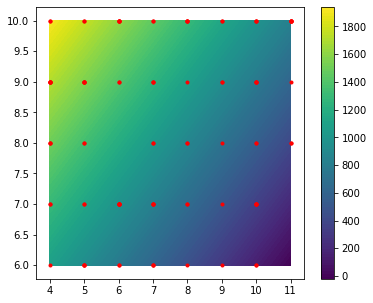

In [26]:
random.seed(41)
monte_carlo(100)
# When Train per hour is 10
# Train interval is 6

(1, 11, 6, -15.163299999999936)

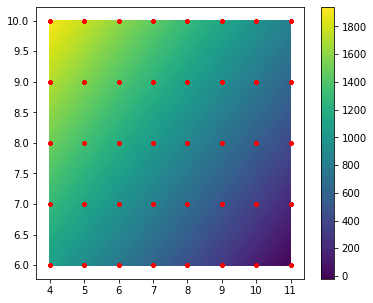

In [27]:
random.seed(50)
monte_carlo(500)
# When Train per hour is 6
# Train interval is 10

(1, 11, 8, 404.4553000000001)

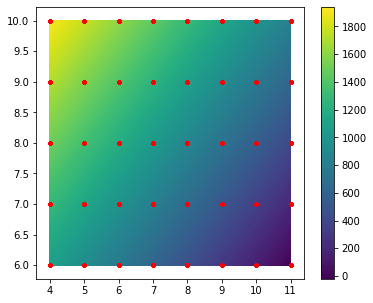

In [28]:
random.seed(50)
monte_carlo(20000)
# When Train per hour is 8
# Train interval is 6

(1, 11, 7, 194.64600000000019)

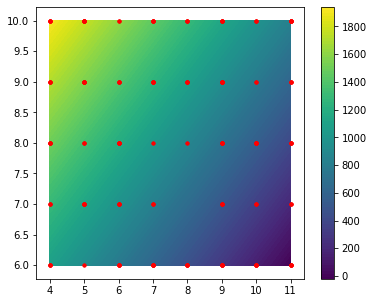

In [29]:
random.seed(975898)
monte_carlo(250)
# When Train per hour is 8
# Train interval is 6

In [35]:
# neccessary imports
import pulp
from pulp import *
prob = LpProblem("Maximize number of Passengers",LpMinimize)
# LpVariable("name", lb, ub, varType)
x1 = LpVariable("total_blocks", 3, 13, LpInteger)
x2 = LpVariable("total_trains_per_hour",6, 16, LpInteger)
# Objective
prob += 449.0231 + (-156.6402)*x1 + 209.8093*x2
# Write problem data to an .lp file
prob.writeLP("optimal_number_passenger_per_hour.lp")
prob.solve()
print("Status:", LpStatus[prob.status])
for v in prob.variables():
    print(v.name, "=", v.varValue)
int(pulp.value(prob.objective))

Status: Optimal
total_blocks = 13.0
total_trains_per_hour = 6.0


-328

The optimized results in context of time have been generated with random.seed(40), when the number of blocks are 10 between stations, 6 trains can travel with minimum travel time of approx 1313 seconds.

(2, 11, 9, 614.2646)

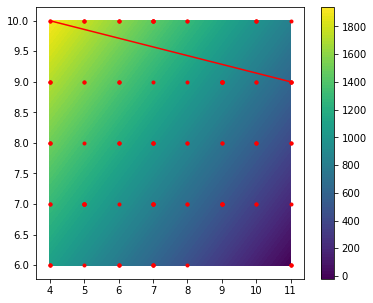

In [33]:
random.seed(31)
monte_carlo(100)

For random.seed(31), when the number of blocks are 2 between stations, 11 trains can travel with maximum travel time of approx 614 seconds.